# Models



|            | [1] DeepFold | [2] SeqVec |
|------------|--------------|------------|
| A. DBSCAN  | A1 | A2 |
| B. HDBSCAN | B1 | B2 |
| C. OPTICS  | C1 | C2 |



Model files generated

```
Upload: model_outputs/A1-DBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/a1_model.pkl
Upload: model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/b2_model.pkl
Upload: model_outputs/B2-HDBSCAN-SeqVec-cluster_stats.parquet
Upload: model_outputs/a2_model.pkl
Upload: model_outputs/b1_model.pkl
Upload: model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/A2-DBSCAN-SeqVec-cluster_stats.parquet
```

In [1]:
from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import importlib
import hdbscan
from sklearn.cluster import DBSCAN
import io
import os
import pickle

In [2]:
a1_model = gcs.download_pkl('model_outputs/a1_model.pkl')
a2_model = gcs.download_pkl('model_outputs/a2_model.pkl')
b1_model = gcs.download_pkl('model_outputs/b1_model.pkl')
b2_model = gcs.download_pkl('model_outputs/b2_model.pkl')


In [41]:

def get_noise_stats(model):
    labels = np.unique(model.labels_, return_counts=True)
    noise_ct = labels[1][0]
    max_cluster_size = labels[1][1:].max()
    num_proteins=model.labels_.shape[0]


    print("Noise:", noise_ct)
    print("Largest non-noise cluster:", max_cluster_size)
    print("Noise as % of total =", noise_ct, "/", num_proteins, "=", noise_ct/num_proteins)
    print("Noise and largest cluster as % of total = ()", noise_ct, "+", max_cluster_size, ")/", 
          num_proteins, "=", (noise_ct+max_cluster_size)/num_proteins)


In [42]:
get_noise_stats(a1_model)

Noise: 10240
Largest non-noise cluster: 5451
Noise as % of total = 10240 / 20301 = 0.504408649820206
Noise and largest cluster as % of total = () 10240 + 5451 )/ 20301 = 0.7729175902664893


In [43]:
get_noise_stats(a2_model)

Noise: 12966
Largest non-noise cluster: 691
Noise as % of total = 12966 / 20504 = 0.6323644166991806
Noise and largest cluster as % of total = () 12966 + 691 )/ 20504 = 0.6660651580179477


In [44]:
get_noise_stats(b1_model)

Noise: 13525
Largest non-noise cluster: 292
Noise as % of total = 13525 / 19315 = 0.7002329795495729
Noise and largest cluster as % of total = () 13525 + 292 )/ 19315 = 0.7153507636551902


In [45]:
get_noise_stats(b2_model)

Noise: 11579
Largest non-noise cluster: 416
Noise as % of total = 11579 / 20504 = 0.5647190792040577
Noise and largest cluster as % of total = () 11579 + 416 )/ 20504 = 0.5850078033554429


# Download Embeddings

## 1. DeepFold

In [31]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [25]:
prefix = 'embeddings/DeepFold/withMask=false/'
keys = gcs.list_file_paths(prefix)[1:]

In [26]:
keys

['gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_00.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_01.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_02.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_03.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_04.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_05.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_06.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_07.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_08.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_09.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/withMask=false/embeddings_10.csv',
 'gs://capstone-fall21-protein/embeddings/DeepFold/wit

In [32]:
X_deepfold, missing_deepfold, protein_id_deepfold = ev.import_deepfold_embeddings(keys)

embeddings/DeepFold/withMask=false/embeddings_00.csv
embeddings/DeepFold/withMask=false/embeddings_01.csv
embeddings/DeepFold/withMask=false/embeddings_02.csv
embeddings/DeepFold/withMask=false/embeddings_03.csv
embeddings/DeepFold/withMask=false/embeddings_04.csv
embeddings/DeepFold/withMask=false/embeddings_05.csv
embeddings/DeepFold/withMask=false/embeddings_06.csv
embeddings/DeepFold/withMask=false/embeddings_07.csv
embeddings/DeepFold/withMask=false/embeddings_08.csv
embeddings/DeepFold/withMask=false/embeddings_09.csv
embeddings/DeepFold/withMask=false/embeddings_10.csv
embeddings/DeepFold/withMask=false/embeddings_11.csv
embeddings/DeepFold/withMask=false/embeddings_12.csv
embeddings/DeepFold/withMask=false/embeddings_13.csv
embeddings/DeepFold/withMask=false/embeddings_14.csv
embeddings/DeepFold/withMask=false/embeddings_15.csv
embeddings/DeepFold/withMask=false/embeddings_16.csv
embeddings/DeepFold/withMask=false/embeddings_17.csv
embeddings/DeepFold/withMask=false/embeddings_

In [33]:
print("X_deepfold.shape", X_deepfold.shape)
print("missing_deepfold.shape", missing_deepfold.shape)
print("protein_id_deepfold.shape", protein_id_deepfold.shape)

X_deepfold.shape (20301, 398)
missing_deepfold.shape (203,)
protein_id_deepfold.shape (20301,)


(100, 100)
0.05531216821492077 1.3958603498450148 1.1258949664407183


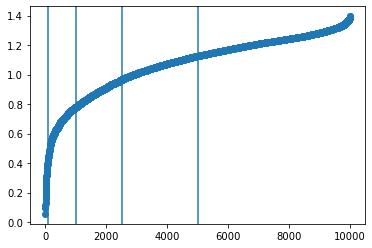

In [32]:
# Show euclidean distances between a random set of points

ed = euclidean_distances(X_deepfold[np.random.choice(range(len(X_deepfold)), 100)],
                         X_deepfold[np.random.choice(range(len(X_deepfold)), 100)]
                        )
print(ed.shape)

min_ed = np.min(ed)
max_ed = np.max(ed)
median_ed = np.median(ed)

print(min_ed, max_ed, median_ed)
ed_flatten = ed.flatten()

plt.scatter(range(len(ed_flatten)), np.sort(ed_flatten))
plt.axvline(len(ed_flatten)/2)
plt.axvline(len(ed_flatten)/4)
plt.axvline(len(ed_flatten)/10)
plt.axvline(len(ed_flatten)/100)
plt.show()

The euclidean distance among the proteins range from 0 to 1.41, median is about 1.12. And based on the plot of euclidean distances, it appears that there are a lot of proteins that are similar to each other and there is a long tail of different proteins. 

## 2. SeqVec

In [11]:
prefix = 'embeddings/SeqVec/'
keys = gcs.list_file_paths(prefix)

# There's only one file 
key = gcs.uri_to_bucket_and_key(keys[1])[1]
seqvec_df = gcs.download_pkl(key)

# Convert pd Series into np arr
X_seqvec = np.stack( seqvec_df["seqvec"]).astype(np.float64)

X_seqvec.shape

(20504, 1024)

In [12]:
protein_id_seqvec = np.array(seqvec_df["protein_id"])

In [13]:
protein_id_seqvec.shape

(20504,)

# Modeling

## A. DBSCAN

### A.1. DBSCAN + DeepFold

In [34]:
range_eps = np.linspace(start=0.1, stop=1.4, num=6)
range_min_samples = [2, 5, 10]

a1_gridsearch = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='euclidean')

0.1 2
0.1 5
0.1 10
0.36 2
0.36 5
0.36 10
0.6199999999999999 2
0.6199999999999999 5
0.6199999999999999 10
0.8799999999999998 2
0.8799999999999998 5
0.8799999999999998 10
1.14 2
1.14 5
1.14 10
1.4 2
1.4 5
1.4 10


In [35]:
a1_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
17,1.40,10,euclidean,0,0,None,None,None,None,None
15,1.40,2,euclidean,0,0,None,None,None,None,None
14,1.14,10,euclidean,0,0,None,None,None,None,None
13,1.14,5,euclidean,0,0,None,None,None,None,None
12,1.14,2,euclidean,0,0,None,None,None,None,None
16,1.40,5,euclidean,0,0,None,None,None,None,None
9,0.88,2,euclidean,23,146,20100,1.586657,0.041818,1.117051,0.042953
10,0.88,5,euclidean,1,214,None,None,None,None,None
11,0.88,10,euclidean,1,258,None,None,None,None,None
6,0.62,2,euclidean,593,2610,15346,1.355311,-0.131881,1.103202,-0.110608


None of these models look usable because either there's too much noise or too much concentration in one giant cluster. The best it can do is 8684 in noise plus 7433 in a big cluster, at a total of about 16,000 untrustworthy protein clustering.
Try again with cosine distance.

In [36]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [2, 5, 10]

a1_gridsearch  = ev.dbscan_gridsearch(X_deepfold, range_eps, range_min_samples, metric='cosine')

0.05 2
0.05 5
0.05 10
0.2625 2
0.2625 5
0.2625 10
0.475 2
0.475 5
0.475 10
0.6875 2
0.6875 5
0.6875 10
0.9 2
0.9 5
0.9 10


In [37]:
a1_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
9,0.6875,2,cosine,0,0,None,None,None,None,None
10,0.6875,5,cosine,0,0,None,None,None,None,None
11,0.6875,10,cosine,0,0,None,None,None,None,None
12,0.9000,2,cosine,0,0,None,None,None,None,None
13,0.9000,5,cosine,0,0,None,None,None,None,None
14,0.9000,10,cosine,0,0,None,None,None,None,None
6,0.4750,2,cosine,2,8,20290,2.362348,0.118469,1.023969,0.123562
7,0.4750,5,cosine,1,11,None,None,None,None,None
8,0.4750,10,cosine,1,11,None,None,None,None,None
3,0.2625,2,cosine,282,1258,18076,1.404573,-0.093246,1.137328,-0.0843


The least egregious seems to be the modein index `0`, despite a large number of clusters (1,223).

In [38]:
a1_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_deepfold)

In [39]:
file_path = 'model_outputs/a1_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(a1_model, file)

### A.2. DBSCAN + SeqVec

In [25]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [26]:
# With cosine 
range_eps = np.linspace(start=0.05, stop=0.9, num=5)
range_min_samples = [1, 2, 5, 10]

a2_gridsearch  = ev.dbscan_gridsearch(X_seqvec, range_eps, range_min_samples, metric='cosine')

0.05 1
0.05 2
0.05 5
0.05 10
0.2625 1
0.2625 2
0.2625 5
0.2625 10
0.475 1
0.475 2
0.475 5
0.475 10
0.6875 1
0.6875 2
0.6875 5
0.6875 10
0.9 1
0.9 2
0.9 5
0.9 10


In [27]:
a2_gridsearch

,eps,min_samples,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,0.0500,1,cosine,14571,0,691,0.535717,0.094725,0.535717,0.094725
17,0.9000,2,cosine,0,0,None,None,None,None,None
16,0.9000,1,cosine,0,0,None,None,None,None,None
15,0.6875,10,cosine,0,0,None,None,None,None,None
14,0.6875,5,cosine,0,0,None,None,None,None,None
13,0.6875,2,cosine,0,0,None,None,None,None,None
12,0.6875,1,cosine,0,0,None,None,None,None,None
11,0.4750,10,cosine,0,0,None,None,None,None,None
10,0.4750,5,cosine,0,0,None,None,None,None,None
9,0.4750,2,cosine,0,0,None,None,None,None,None


The least aggregious seems to be index 1. That's the same set of params as model a1 with a different embedding.

In [18]:
a2_model = DBSCAN(eps=0.0500, 
                  min_samples=2,
                  metric='cosine').fit(X_seqvec)

In [19]:
# file_path = 'model_outputs/a2_model.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(a2_model, file)

## B. HDBSCAN

`min_cluster_size` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
> Clusters smaller than this value with be called ‘noise’ and remain unclustered in the resulting flat clustering


`min_samples` [More info](https://readthedocs.org/projects/hdbscan/downloads/pdf/latest/)
>  The simplest intuition for what min_samples does is provide a measure of how conservative
you want you clustering to be. The larger the value of min_samples you provide, the more conservative the
clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. [...] Note: adjusting min_samples will result in recomputing the hard comptuation of the single linkage
tree.

`cluster_selection_epsilon` [More info](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)
> In some cases, we want to choose a small min_cluster_size because even groups of few points might be of interest to us. However, if our data set also contains partitions with high concentrations of objects, this parameter setting can result in a large number of micro-clusters. Selecting a value for cluster_selection_epsilon helps us to merge clusters in these regions. Or in other words, it ensures that clusters below the given threshold are not split up any further.


### B.1. HDBSCAN + DeepFold

In [46]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 1.1, 1.3]  # I tried a lot of epsilons 0-1.0 but they did not make any difference

b1_gridsearch = ev.hdbscan_gridsearch(X_deepfold, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

KeyboardInterrupt: 

In [ ]:
b1_gridsearch

The noise is too high. And the param `cluster_selection_epsilon` isn't doing anything. 

In [47]:
b1_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b1_model.fit(X_deepfold)

KeyboardInterrupt: 

In [ ]:
file_path = 'model_outputs/b1_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(b1_model, file)

### B.2. HDBSCAN + SeqVec

In [104]:
min_cluster_sizes = [5, 10]
min_samples = [1, 5]
cluster_selection_epsilons = [0, 0.2, 0.5, 1.0]

b2_gridsearch = ev.hdbscan_gridsearch(X_seqvec, 
                                       min_cluster_sizes,
                                       min_samples,
                                       cluster_selection_epsilons
                                      )

In [105]:
b2_gridsearch

,min_cluster_size,min_sample,cluster_selection_epsilon,alpha,metric,Num. Clusters,Noise Size,Max Cluster Size,DB_sc,Silhouette_sc,DB_sc excl. noise,Silhouette_sc excl. noise
0,5,1,0,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
1,5,1,0.2,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
2,5,1,0.5,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
3,5,1,1.0,1.0,cosine,757,11579,416,1.592354,-0.141107,1.347855,0.234666
8,10,1,0,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
9,10,1,0.2,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
10,10,1,0.5,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
11,10,1,1.0,1.0,cosine,292,12789,416,1.643406,-0.133924,1.407526,0.243833
4,5,5,0,1.0,cosine,343,14433,401,1.400991,-0.175680,1.060436,0.335780
5,5,5,0.2,1.0,cosine,343,14433,401,1.400991,-0.175680,1.060436,0.335780


In [30]:
b2_model = hdbscan.HDBSCAN(algorithm='generic', 
                                     alpha= 1.0, 
                                     approx_min_span_tree=True,
                                     gen_min_span_tree=False, 
                                     leaf_size=40, 
                                     metric='cosine', 
                                     min_cluster_size= 5, 
                                     min_samples= 1, 
                                     p=None)
b2_model.fit(X_seqvec)

HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)

In [31]:
# file_path = 'model_outputs/b2_model.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(b2_model, file)

# Evaluation


In [108]:
# Download lookup files
pairwise_metrics = pd.read_csv(io.StringIO(gcs.download_text('annotations/blast_annotations.csv')))
pairwise_metrics = pairwise_metrics.drop_duplicates()
asp = ev.download_asp()
sequences = gcs.download_parquet("structure_files/sequences/sequences.parquet")
sequences["seq_len"] = sequences["pdbx_seq_one_letter_code"].str.len()

In [192]:
# TO DO: Need to fix this pairwise metrics lookup table. Danie to remove dupes.

In [335]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [338]:
models = {
          'A1': ('DBSCAN' , 'DeepFold', a1_model, protein_id_deepfold),
          'A2': ('DBSCAN' , 'SeqVec',   a2_model, protein_id_seqvec),
          'B1': ('HDBSCAN', 'DeepFold', b1_model, protein_id_deepfold),
          'B2': ('HDBSCAN', 'SeqVec',   b2_model, protein_id_seqvec)
         }

for model_code, vals in models.items():
    algo, embed, model, protein_id = vals 
    
    clusters = pd.DataFrame({'protein':      protein_id, 
                            'cluster_label': model.labels_})
    
    with open('model_outputs/'+ model_code +'_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    # output all protein combos for TM Align calc 
    all_protein_combos_per_cluster = ev.find_all_protein_combos_per_cluster(clusters, 
                                                                            exclude_unclustered=True)
    
    all_protein_combos_per_cluster.to_parquet('model_outputs/' + model_code + '-' + algo + '-' + embed + "-all_protein_combos_per_cluster.parquet")
    
    # Output proteins with blast - this might cause issues later for the final selected model if missing. 
    # ... since we sample to calculate BLAST scores from particularly large clusters. 
    proteins_w_blast = ev.join_blast(clusters, pairwise_metrics, all_protein_combos_per_cluster)
    # proteins_w_blast.to_parquet('model_outputs/' + model_code + '-' + algo + '-' + embed + '-proteins_w_blast.parquet')
    
    # Output clusters with blast aggregation 
    # Excludes noise (-1)
    blast_stats_by_cluster = ev.cluster_blast(proteins_w_blast).set_index("cluster")
    
    # Confidence level per protein 
    cluster_conf = ev.protein_confidence_agg(clusters, asp)
    
    # Sequence stats
    sequence_stats = ev.sequence_stats(clusters, sequences).set_index("cluster_label")
    
    cluster_stats = ev.merge_cluster_stats(cluster_conf, sequence_stats)
    
    cluster_stats = ev.merge_cluster_stats(cluster_stats, blast_stats_by_cluster)
    
    # Reorder columns
    cluster_stats['model'] = algo
    cluster_stats['embedding'] = embed
    first_cols = ['model', 'embedding', 'num_proteins'] 
    ordered_cols = first_cols + list(cluster_stats.columns[~cluster_stats.columns.isin(first_cols)])
    ordered_cols
    cluster_stats = cluster_stats.reindex(columns=ordered_cols)

    cluster_stats.to_parquet('model_outputs/' + model_code + '-' + algo + '-' + embed + '-cluster_stats.parquet')


**Upload all files onto gcs**

In [32]:
home_path = os.getcwd()
prefix = 'model_outputs/'

for file in os.listdir(home_path + '/' + prefix):
    if ('.parquet' in file) or ('.pkl' in file):
        print("Upload: "+prefix + file)
        gcs.upload_blob(home_path+ '/' + prefix + file, 
                        prefix + file)

Upload: model_outputs/A1-DBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/a1_model.pkl
Upload: model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-cluster_stats.parquet
Upload: model_outputs/b2_model.pkl
Upload: model_outputs/B2-HDBSCAN-SeqVec-cluster_stats.parquet
Upload: model_outputs/a2_model.pkl
Upload: model_outputs/b1_model.pkl
Upload: model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
Upload: model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
Upload: model_outputs/A2-DBSCAN-SeqVec-cluster_stats.parquet


# Final Model

In [ ]:
# Reduce to 3D space for visualization
model_of_choice = b2_model # subject to change 

from sklearn.manifold import Isomap

print("X_full orig shape", seqvec_np.shape)

embedding = Isomap(n_components=3)
model_of_choice_3d = embedding.fit_transform(model_of_choice)
print("X_transformed new shape", model_of_choice_3d.shape)

In [ ]:
pd.DataFrame(model_of_choice_3d, columns=['x', 'y', 'z']).head()

In [ ]:
clusters_with_3d = pd.concat([clusters, pd.DataFrame(model_of_choice_3d, columns=['x', 'y', 'z'])], 
                             axis=1)
clusters_with_3d.to_parquet(path="proteins_with_clusters_n_3d_embed.parquet")
gcs.upload_blob('proteins_with_clusters_n_3d_embed.parquet', filename)